Folder archive already exists; skipping extraction.
Folder ferdata already exists; skipping extraction.
Total images loaded: 41200
               dataset  label  \
0  emotion_recognition  Angry   
1  emotion_recognition  Angry   
2  emotion_recognition  Angry   
3  emotion_recognition  Angry   
4  emotion_recognition  Angry   

                                          image_path  
0  archive\dataset\Angry\00a7cb9cf18d3a015a9e9329...  
1  archive\dataset\Angry\00b7e4551ffa57ff4e2311b2...  
2  archive\dataset\Angry\0118d3f7d8cbda624679c102...  
3  archive\dataset\Angry\016e982434c5ffc7ee2fdc35...  
4  archive\dataset\Angry\01b4484e9f51114bbdaceb1e...  

Image counts by dataset and label:
                dataset     label  count
0   emotion_recognition    Ahegao   1205
1   emotion_recognition     Angry   1313
2   emotion_recognition     Happy   3740
3   emotion_recognition   Neutral   4027
4   emotion_recognition       Sad   3934
5   emotion_recognition  Surprise   1234
6               f

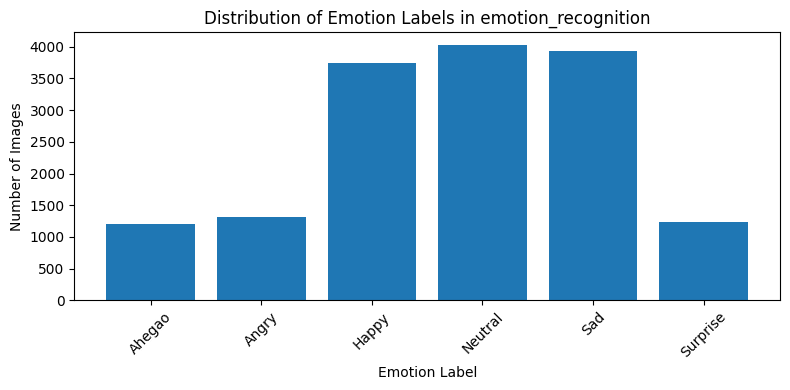

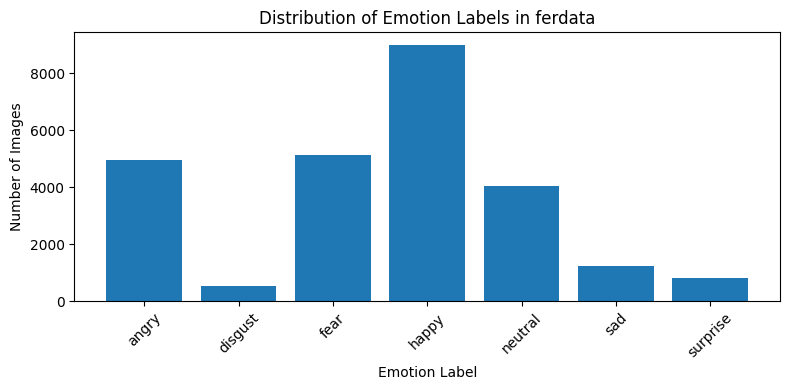

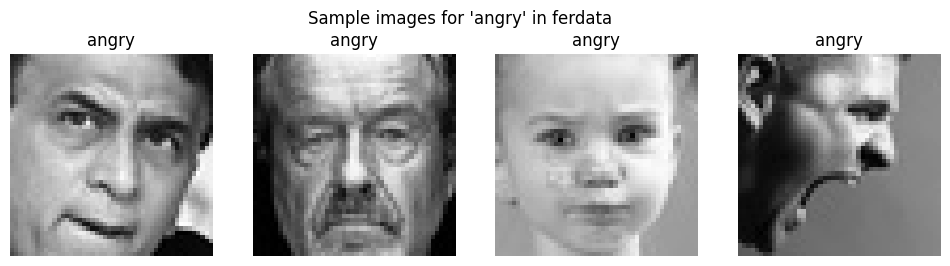

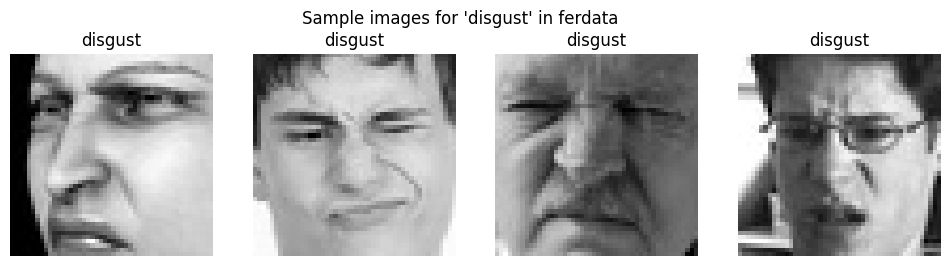

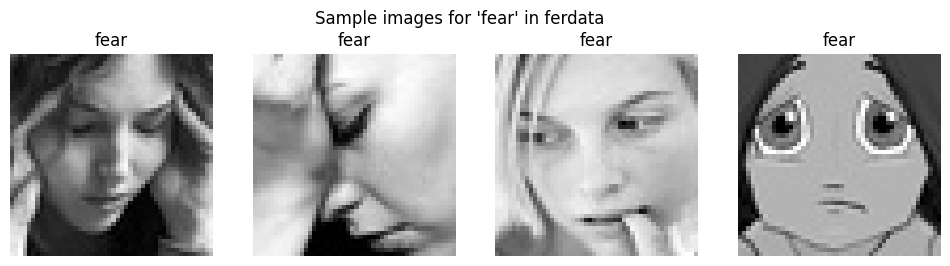

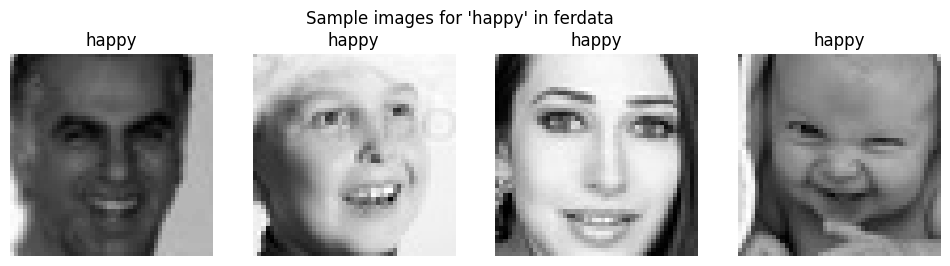

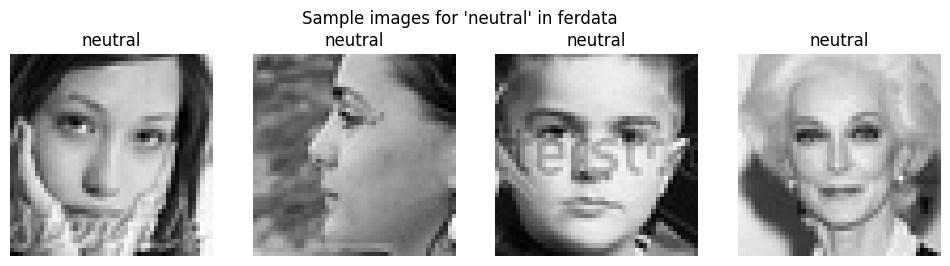

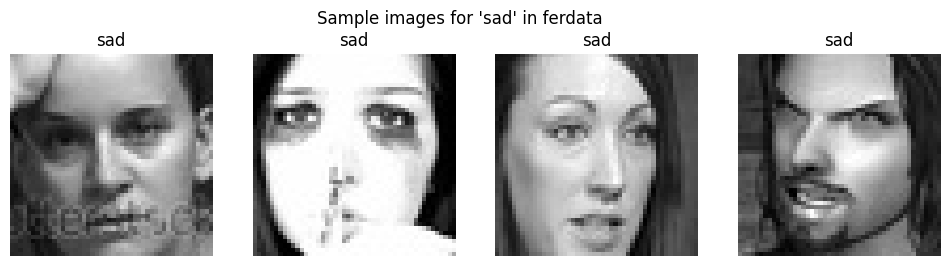

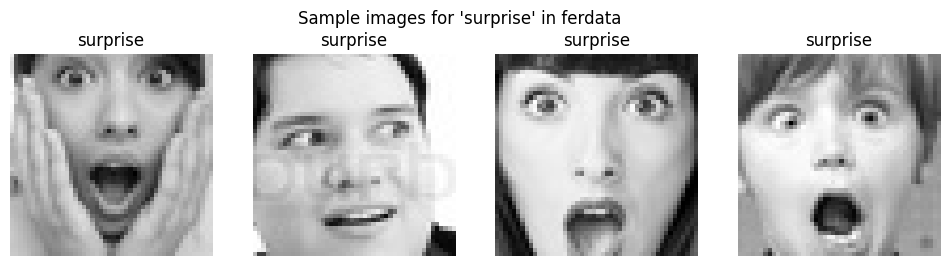

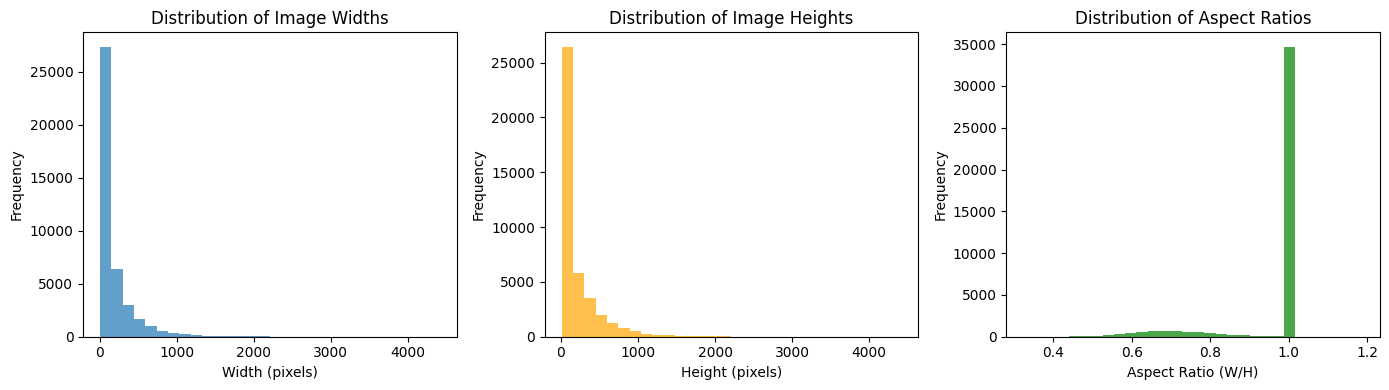

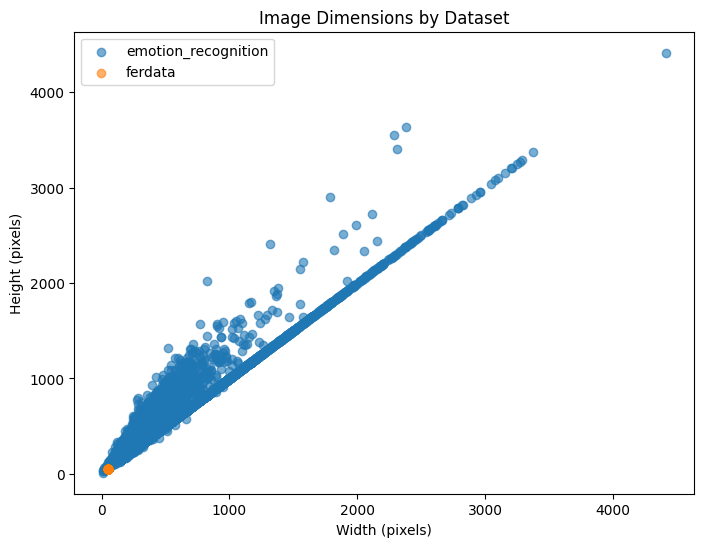

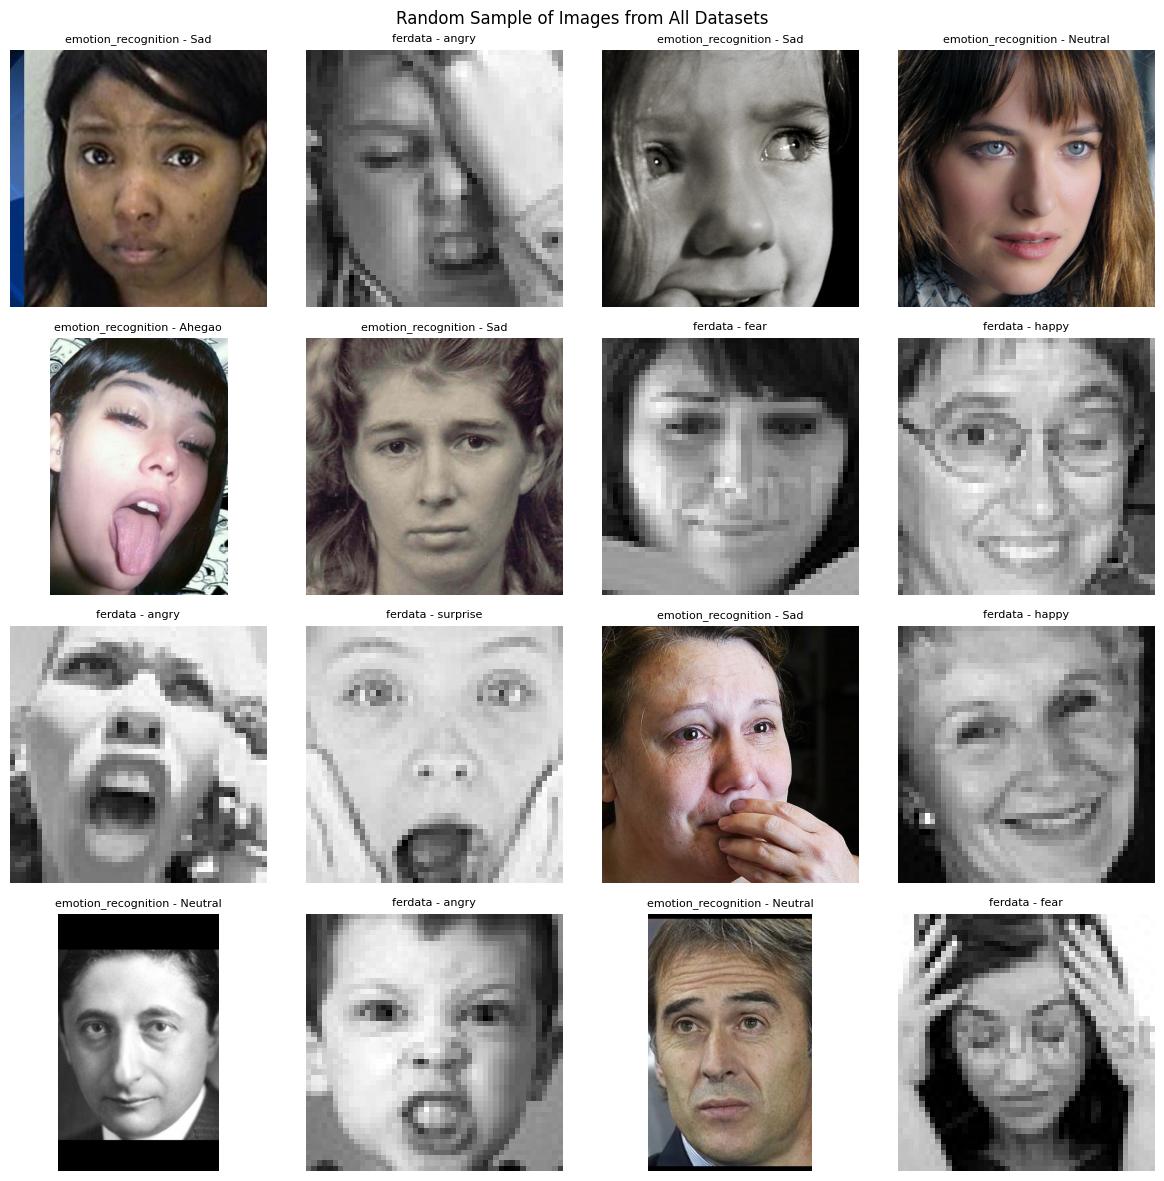

Summary statistics by dataset:
                       width                                              \
                       count        mean         std   min    25%    50%   
dataset                                                                    
emotion_recognition  15453.0  406.431373  343.894101   8.0  204.0  293.0   
ferdata              25747.0   48.000000    0.000000  48.0   48.0   48.0   

                                     height             ...                 \
                       75%     max    count       mean  ...    75%     max   
dataset                                                 ...                  
emotion_recognition  489.0  4414.0  15453.0  458.13499  ...  560.0  4414.0   
ferdata               48.0    48.0  25747.0   48.00000  ...   48.0    48.0   

                    aspect_ratio                                               \
                           count      mean       std       min       25%  50%   
dataset                            

In [1]:
import os
import zipfile
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# --- Helper Functions ---

def extract_zip(zip_path, extract_to):
    """
    Extracts a zip file to the given directory.
    If the directory already exists, extraction is skipped.
    """
    if os.path.exists(extract_to):
        print(f"Folder {extract_to} already exists; skipping extraction.")
        return
    print(f"Extracting {zip_path} to {extract_to}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def get_images_from_dir(root_dir, dataset_name):
    """
    Recursively scans root_dir for image files and infers the label
    from the immediate parent folder name. Returns a list of dictionaries.
    Supports common image formats.
    """
    image_extensions = ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.pgm')
    data = []
    for ext in image_extensions:
        for img_path in glob.glob(os.path.join(root_dir, '**', ext), recursive=True):
            # Assume the folder directly above the image is the label.
            label = os.path.basename(os.path.dirname(img_path))
            data.append({'dataset': dataset_name, 'label': label, 'image_path': img_path})
    return data

def show_sample_images(df, label, dataset_name, samples=4):
    """
    Displays a few sample images for a given label from a specific dataset.
    """
    subset = df[(df['dataset'] == dataset_name) & (df['label'] == label)]
    sample_paths = subset['image_path'].sample(min(samples, len(subset))).tolist()
    
    plt.figure(figsize=(12, 3))
    for i, img_path in enumerate(sample_paths):
        try:
            img = Image.open(img_path)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
        plt.subplot(1, samples, i + 1)
        plt.imshow(img, cmap='gray' if img.mode=='L' else None)
        plt.axis('off')
        plt.title(label)
    plt.suptitle(f"Sample images for '{label}' in {dataset_name}")
    plt.show()

def add_image_sizes(df):
    """
    Adds image dimensions (width and height) and aspect ratio to the DataFrame.
    """
    widths, heights, aspect_ratios = [], [], []
    for idx, row in df.iterrows():
        try:
            img = Image.open(row['image_path'])
            w, h = img.size
        except Exception as e:
            print(f"Error reading {row['image_path']}: {e}")
            w, h = None, None
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(w/h if (w and h) else None)
    df['width'] = widths
    df['height'] = heights
    df['aspect_ratio'] = aspect_ratios
    return df

def show_dimension_distributions(df):
    """
    Creates visualizations for image dimensions:
      - Histograms of image widths, heights, and aspect ratios.
      - A scatter plot of width vs height colored by dataset.
    """
    df_clean = df.dropna(subset=['width', 'height', 'aspect_ratio'])
    
    plt.figure(figsize=(14, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(df_clean['width'], bins=30, alpha=0.7)
    plt.xlabel("Width (pixels)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Image Widths")
    
    plt.subplot(1, 3, 2)
    plt.hist(df_clean['height'], bins=30, alpha=0.7, color='orange')
    plt.xlabel("Height (pixels)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Image Heights")
    
    plt.subplot(1, 3, 3)
    plt.hist(df_clean['aspect_ratio'], bins=30, alpha=0.7, color='green')
    plt.xlabel("Aspect Ratio (W/H)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Aspect Ratios")
    
    plt.tight_layout()
    plt.show()
    
    # Scatter plot: width vs height by dataset
    plt.figure(figsize=(8, 6))
    for d in df_clean['dataset'].unique():
        subset = df_clean[df_clean['dataset'] == d]
        plt.scatter(subset['width'], subset['height'], alpha=0.6, label=d)
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.title("Image Dimensions by Dataset")
    plt.legend()
    plt.show()

def show_random_montage(df, num_images=16):
    """
    Displays a montage (grid) of random images from all datasets with their dataset and label.
    """
    sample_df = df.sample(min(num_images, len(df)))
    grid_size = int(num_images**0.5)
    plt.figure(figsize=(12, 12))
    for i, (_, row) in enumerate(sample_df.iterrows()):
        try:
            img = Image.open(row['image_path'])
        except Exception as e:
            print(f"Error loading {row['image_path']}: {e}")
            continue
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img, cmap='gray' if img.mode=='L' else None)
        plt.title(f"{row['dataset']} - {row['label']}", fontsize=8)
        plt.axis('off')
    plt.suptitle("Random Sample of Images from All Datasets")
    plt.tight_layout()
    plt.show()

def show_summary_statistics(df):
    """
    Displays descriptive statistics for image dimensions and aspect ratios per dataset.
    """
    summary = df.groupby('dataset')[['width', 'height', 'aspect_ratio']].describe()
    print("Summary statistics by dataset:")
    print(summary)

# --- Main EDA Script ---

# Define the paths to your zip files and extraction folders for the two datasets.
zip_files = {
    "emotion_recognition": "archive.zip",  # update with your file paths
    "ferdata": "ferdata.zip"               # update with your file paths
}

extraction_dirs = {
    "emotion_recognition": "archive",
    "ferdata": "ferdata"
}

# Extract the zip files if needed.
for key in zip_files:
    extract_zip(zip_files[key], extraction_dirs[key])

# Gather image paths and labels from each dataset.
all_data = []
for key in extraction_dirs:
    dataset_dir = extraction_dirs[key]
    data = get_images_from_dir(dataset_dir, key)
    all_data.extend(data)

# Create a DataFrame for analysis.
df = pd.DataFrame(all_data)
print("Total images loaded:", len(df))
print(df.head())

# Add image dimensions (width, height) and aspect ratio to the DataFrame.
df = add_image_sizes(df)

# Count images per dataset and label.
count_df = df.groupby(['dataset', 'label']).size().reset_index(name='count')
print("\nImage counts by dataset and label:")
print(count_df)

# Visualization 1: Bar chart for each dataset showing the distribution of labels.
datasets = df['dataset'].unique()
for dataset in datasets:
    subset = count_df[count_df['dataset'] == dataset]
    plt.figure(figsize=(8, 4))
    plt.bar(subset['label'], subset['count'])
    plt.title(f"Distribution of Emotion Labels in {dataset}")
    plt.xlabel("Emotion Label")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualization 2: Display sample images for each label in the ferdata dataset.
selected_dataset = "ferdata"
labels = df[df['dataset'] == selected_dataset]['label'].unique()
for label in labels:
    show_sample_images(df, label, selected_dataset, samples=4)

# Visualization 3: Image dimension analysis.
show_dimension_distributions(df)

# Visualization 4: Montage of random images from all datasets.
show_random_montage(df)

# Visualization 5: Print summary statistics of image sizes.
show_summary_statistics(df)


Average intensity summary statistics:
count    41200.000000
mean       124.551422
std         32.918512
min          0.000000
25%        102.540039
50%        124.249343
75%        146.743580
max        245.016493
Name: avg_intensity, dtype: float64


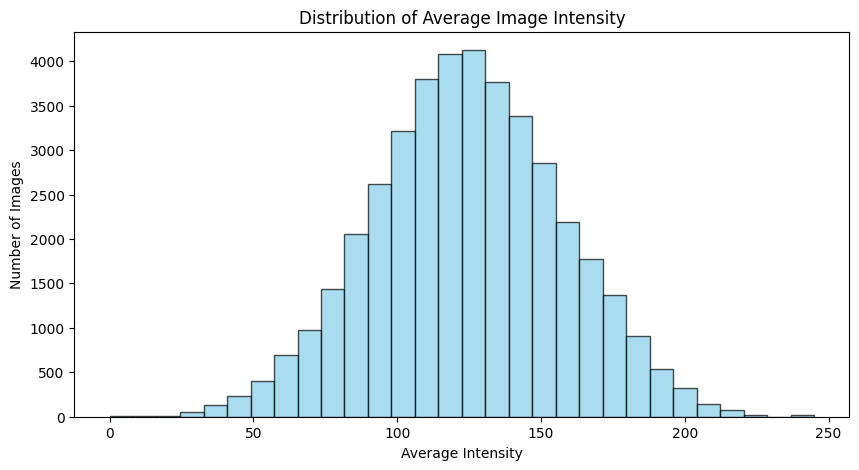

<Figure size 800x500 with 0 Axes>

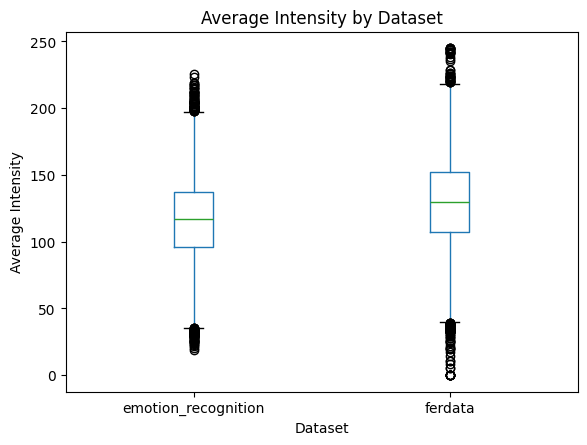

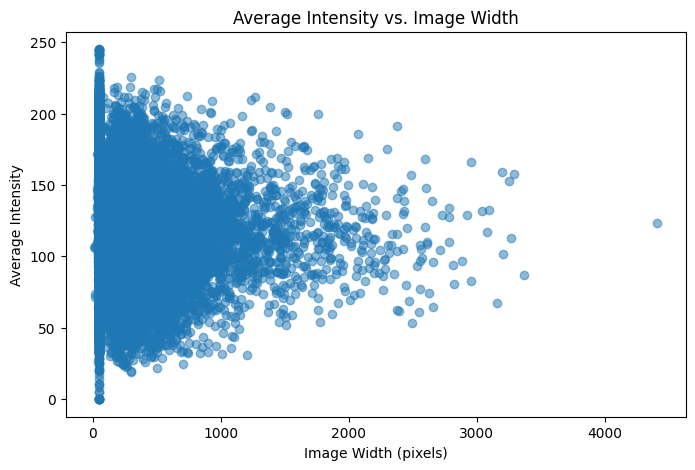

In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to compute average intensity of an image
def compute_avg_intensity(image_path):
    try:
        # Open the image, convert to grayscale
        img = Image.open(image_path).convert('L')
        arr = np.array(img)
        return arr.mean()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return np.nan

# Compute average intensity for each image and add as a new column
df['avg_intensity'] = df['image_path'].apply(compute_avg_intensity)

# Show summary statistics of the average intensity
print("Average intensity summary statistics:")
print(df['avg_intensity'].describe())

# Plot a histogram of average intensities for all images
plt.figure(figsize=(10, 5))
plt.hist(df['avg_intensity'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Average Intensity')
plt.ylabel('Number of Images')
plt.title('Distribution of Average Image Intensity')
plt.show()

# Box plot of average intensities by dataset (if you have multiple datasets)
plt.figure(figsize=(8, 5))
df.boxplot(column='avg_intensity', by='dataset', grid=False)
plt.title('Average Intensity by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Average Intensity')
plt.suptitle('')  # Remove the automatic subtitle
plt.show()

# Scatter plot: average intensity vs. image width (if width info is available)
if 'width' in df.columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(df['width'], df['avg_intensity'], alpha=0.5)
    plt.xlabel('Image Width (pixels)')
    plt.ylabel('Average Intensity')
    plt.title('Average Intensity vs. Image Width')
    plt.show()


Overall Class Distribution:
label
Ahegao      1205
Angry       1313
Happy       3740
Neutral     4027
Sad         3934
Surprise    1234
angry       4953
disgust      547
fear        5121
happy       8989
neutral     4059
sad         1247
surprise     831
Name: count, dtype: int64


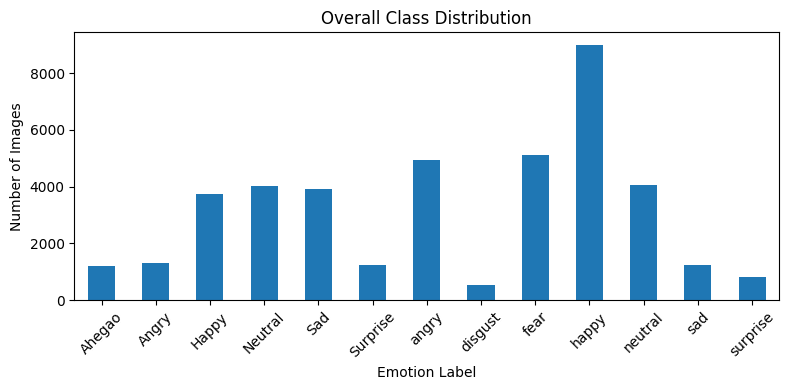

In [9]:
import matplotlib.pyplot as plt

# Compute overall class counts
class_distribution = df['label'].value_counts().sort_index()
print("Overall Class Distribution:")
print(class_distribution)

# Plot the distribution as a bar chart
plt.figure(figsize=(8, 4))
class_distribution.plot(kind='bar')
plt.title("Overall Class Distribution")
plt.xlabel("Emotion Label")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


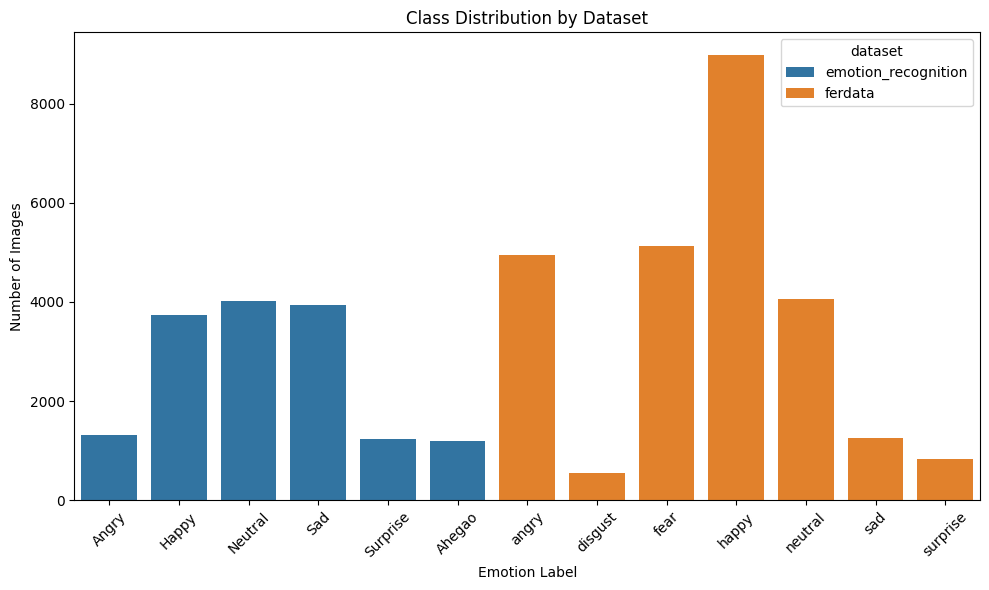

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', hue='dataset')
plt.title("Class Distribution by Dataset")
plt.xlabel("Emotion Label")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Overall Class Distribution (Normalized):
label_normalized
ahegao       1205
angry        6266
disgust       547
fear         5121
happy       12729
neutral      8086
sad          5181
surprise     2065
Name: count, dtype: int64


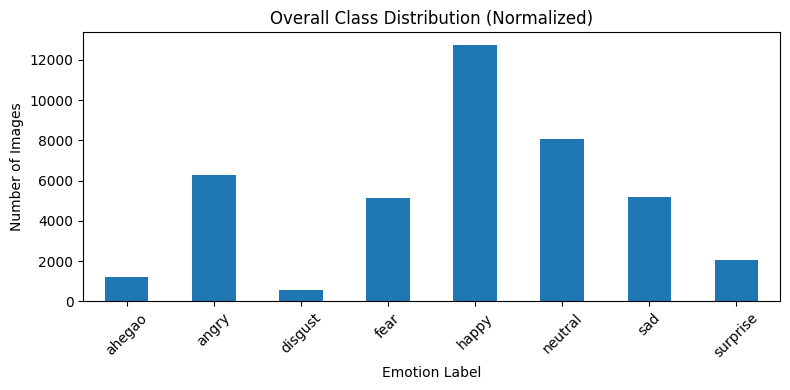

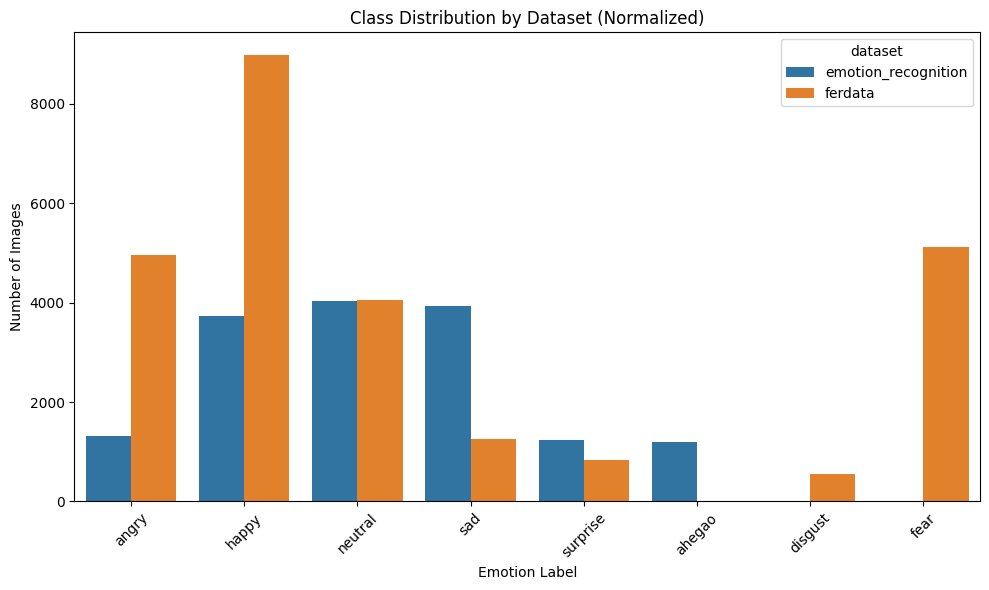

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize the label column: convert to lowercase and strip extra whitespace.
df['label_normalized'] = df['label'].str.lower().str.strip()

# Compute overall class counts using the normalized labels.
class_distribution = df['label_normalized'].value_counts().sort_index()
print("Overall Class Distribution (Normalized):")
print(class_distribution)

# Plot the overall distribution as a bar chart.
plt.figure(figsize=(8, 4))
class_distribution.plot(kind='bar')
plt.title("Overall Class Distribution (Normalized)")
plt.xlabel("Emotion Label")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Plot the distribution by dataset using seaborn.
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label_normalized', hue='dataset')
plt.title("Class Distribution by Dataset (Normalized)")
plt.xlabel("Emotion Label")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
